In [65]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from mirror_autoencoder import MirrorAutoencoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
PATH_GPU = "/home/pgliwny/computer_vision_project/data"
PATH_ADATA = "/media/pgliwny/ADATA HD330/Computer_vision_for_MAGIC/prepare_images/data"
H5_PATH = os.path.join(PATH_GPU, "webcam_images.h5")

In [8]:
event_id = 15
f = h5py.File(H5_PATH, "r")
keys = list(f["images"].keys())
img = f["images"][keys[event_id]]["image"][:]

In [4]:
f.close()

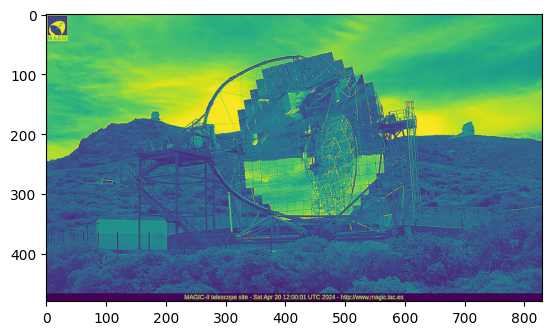

In [5]:
plt.imshow(img)

In [11]:
 f["images"][keys[event_id]]["mirrors"]["mirror_20"]

<HDF5 dataset "mirror_20": shape (17, 19), type "|u1">

In [22]:
f = h5py.File(H5_PATH, "r")
mirror_list = []
for entry_name in f["images"]:
    event = f["images"][entry_name]['mirrors']
    img_array = f["images"][entry_name]['mirrors']['mirror_172'][:]
    mirror_list.append(img_array)

X = np.stack(mirror_list)

f.close()

In [16]:
img_array

array([[  0,   0,   0,   0,   0,   0,   0,   0, 124, 122, 122, 122,  93,
        128, 133,   0],
       [145, 141, 112, 115, 114, 122, 136, 145, 127, 103, 116, 126, 106,
        117, 118,   0],
       [ 80, 153, 100,  83,  88, 104,  99,  74,  82, 110, 114, 142, 136,
        120,  91,   0],
       [158, 254, 241, 232, 182, 119, 148, 221, 253, 223, 241, 251, 248,
        243, 216,   0],
       [159, 251, 254, 246, 251, 252, 252, 228, 219, 217, 207, 192, 176,
        188, 164,   0],
       [137, 239, 226, 218, 216, 197, 208, 207, 219, 214, 214, 211, 215,
        228, 160,   0],
       [152, 205, 184, 186, 230, 210, 212, 203, 205, 211, 214, 209, 204,
        224, 167,   0],
       [171, 203, 225, 213, 171, 192, 227, 229, 229, 221, 204, 208, 216,
        227, 173,   0],
       [144, 216, 218, 204, 218, 203, 185, 142, 203, 210, 218, 220, 221,
        222, 170, 219],
       [  0, 161, 221, 222, 212, 223, 221, 225, 182, 219, 226, 229, 216,
        227, 175, 229],
       [  0, 204, 210, 181, 22

In [18]:
X.shape

(203, 17, 16)

In [19]:
X.reshape(203, 1, 17, 16) 

array([[[[  0,   0,   0, ..., 133, 122,   0],
         [126, 143, 144, ..., 134, 118,   0],
         [112, 137, 100, ..., 121, 106,   0],
         ...,
         [  0, 222, 255, ..., 255, 227, 250],
         [  0, 234, 254, ..., 255, 239, 251],
         [  0, 170, 254, ...,   0,   0,   0]]],


       [[[  0,   0,   0, ..., 101, 109,   0],
         [104, 119, 102, ..., 105, 109,   0],
         [100, 118, 119, ...,  98,  85,   0],
         ...,
         [  0, 140, 179, ..., 165, 118, 138],
         [  0, 137, 219, ..., 187, 175, 173],
         [  0, 105, 177, ...,   0,   0,   0]]],


       [[[  0,   0,   0, ...,  98,  96,   0],
         [102, 100,  91, ...,  93,  97,   0],
         [ 69,  97, 102, ..., 101,  87,   0],
         ...,
         [  0, 123, 154, ..., 156, 117, 135],
         [  0, 124, 178, ..., 139, 126, 139],
         [  0,  77, 146, ...,   0,   0,   0]]],


       ...,


       [[[  0,   0,   0, ..., 107, 106,   0],
         [108, 127,  89, ..., 116, 107,   0],
         [ 4

In [20]:
X.shape

(203, 17, 16)

In [14]:
X.dtype

dtype('uint8')

# Prepare data

To preapre data for Autodecoder, we need resize image to (18, 16)

In [2]:
torch.cuda.is_available() 

True

# Run encoder with pytorch

In [108]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [109]:
X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor = X_tensor.unsqueeze(1)
# zakładając, że X_tensor to oryginalne lustra
X_tensor = X_tensor.float()
X_tensor = (X_tensor - X_tensor.min()) / (X_tensor.max() - X_tensor.min())  # skalowanie do [0, 1]
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [110]:
model = MirrorAutoencoder(feature_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [111]:
for epoch in range(50):
    model.train()
    total_loss = 0.0
    for (batch,) in loader:
        batch = batch.to(device)
        decoded, feature_vector = model(batch)
        loss = loss_fn(decoded, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()*batch.size(0)
    avg = total_loss / len(dataset)
    print(f"Epoch {epoch+1}: recon loss = {avg:.6f}")

Epoch 1: recon loss = 0.107920
Epoch 2: recon loss = 0.092898
Epoch 3: recon loss = 0.072132
Epoch 4: recon loss = 0.067637
Epoch 5: recon loss = 0.064798
Epoch 6: recon loss = 0.061876
Epoch 7: recon loss = 0.058949
Epoch 8: recon loss = 0.055554
Epoch 9: recon loss = 0.051570
Epoch 10: recon loss = 0.047822
Epoch 11: recon loss = 0.044465
Epoch 12: recon loss = 0.040577
Epoch 13: recon loss = 0.035784
Epoch 14: recon loss = 0.030891
Epoch 15: recon loss = 0.027296
Epoch 16: recon loss = 0.024460
Epoch 17: recon loss = 0.022302
Epoch 18: recon loss = 0.021203
Epoch 19: recon loss = 0.020047
Epoch 20: recon loss = 0.018929
Epoch 21: recon loss = 0.018395
Epoch 22: recon loss = 0.017679
Epoch 23: recon loss = 0.017469
Epoch 24: recon loss = 0.016748
Epoch 25: recon loss = 0.016635
Epoch 26: recon loss = 0.015885
Epoch 27: recon loss = 0.015614
Epoch 28: recon loss = 0.015090
Epoch 29: recon loss = 0.014694
Epoch 30: recon loss = 0.014320
Epoch 31: recon loss = 0.014085
Epoch 32: recon l

In [112]:
torch.save(model.state_dict(), "autoencoder_mirror_172.pt")

In [113]:
model.eval()
with torch.no_grad():
    all_features = []
    for (batch,) in loader:
        batch = batch.to(device)
        _, feature_vector = model(batch)
        all_features.append(feature_vector.cpu())
    all_features = torch.cat(all_features, dim=0)

In [114]:
all_features.shape

torch.Size([203, 64])

In [115]:
all_features[5, :]

tensor([-0.8922,  1.4178,  0.1805, -0.2763,  0.2087, -0.6438,  0.2722,  0.8044,
        -0.4072, -0.0889,  0.9412,  0.2452, -0.0703, -0.0278, -0.4465,  0.0914,
        -1.1434, -0.3252, -0.1128,  0.1104,  0.1548, -0.2235, -0.1158, -0.0545,
         0.1082,  0.0551,  0.8275,  0.8921, -0.1131, -0.1201,  0.6750,  0.0529,
         0.1228,  0.7033,  0.2983, -0.6711,  0.2807, -0.6757, -0.6578,  0.2660,
         0.2015,  0.2874, -0.2859,  0.0136, -0.1311, -0.6787, -0.2342, -0.2329,
        -1.0970,  1.3243,  0.9363,  0.9112, -0.1835,  0.1813, -1.2172, -0.4764,
         0.5232,  0.4860, -0.3784, -0.2280,  0.3758, -0.3281,  0.8539, -0.1515])

# Clustering

In [116]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(all_features) 

In [117]:
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(features_scaled)  # kształt (N,2)

In [118]:
tsne = TSNE(n_components=2, random_state=0, init="pca", learning_rate="auto")
tsne_proj = tsne.fit_transform(features_scaled)

In [119]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans_labels = kmeans.fit_predict(features_scaled)

In [143]:
dbscan = DBSCAN(eps=1.75, min_samples=2)
dbscan_labels = dbscan.fit_predict(features_scaled)

In [121]:
def scatter(proj, labels, title):
    plt.figure(figsize=(5,4))
    plt.scatter(proj[:,0], proj[:,1], c=labels, s=15)
    plt.title(title)
    plt.xlabel("dim1")
    plt.ylabel("dim2")
    plt.tight_layout()
    plt.show()

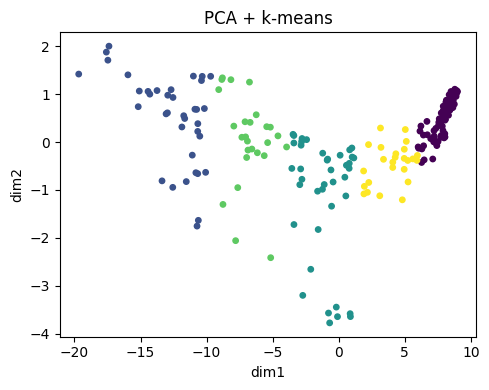

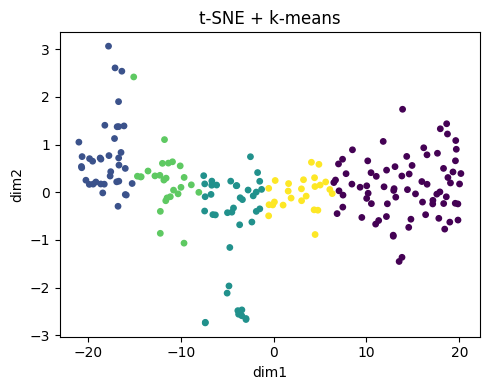

In [122]:
scatter(pca_proj, kmeans_labels, "PCA + k-means")
scatter(tsne_proj, kmeans_labels, "t-SNE + k-means")

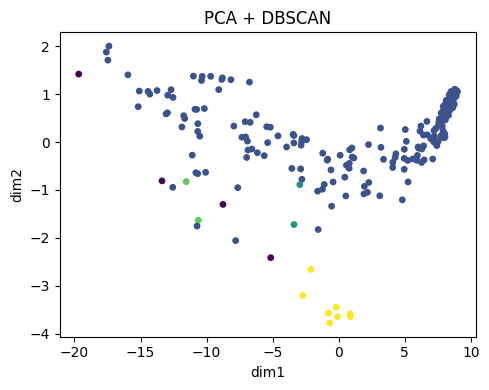

In [144]:
scatter(pca_proj, dbscan_labels, "PCA + DBSCAN")

In [68]:
pca_proj.shape

(203, 2)

In [123]:
np.where(pca_proj[:, 1]<-3)

(array([ 42,  65,  81,  93, 114, 140, 149]),)

In [131]:
np.where(tsne_proj[:, 1]<-2)

(array([ 16,  36,  42,  65,  81,  93, 114, 140, 149]),)

In [66]:
Counter(kmeans_labels)

Counter({np.int32(1): 65,
         np.int32(2): 43,
         np.int32(3): 33,
         np.int32(0): 32,
         np.int32(4): 30})

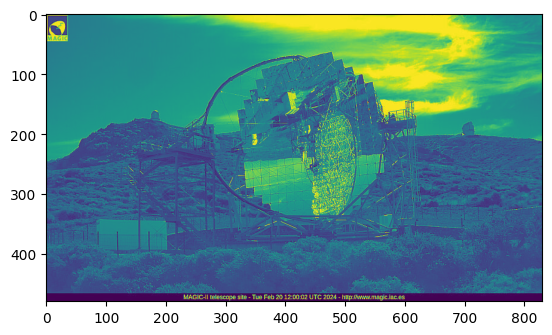

In [150]:
en_i = list(f["images"].keys())[149]
plt.imshow(np.array(f["images"][en_i]["image"]))

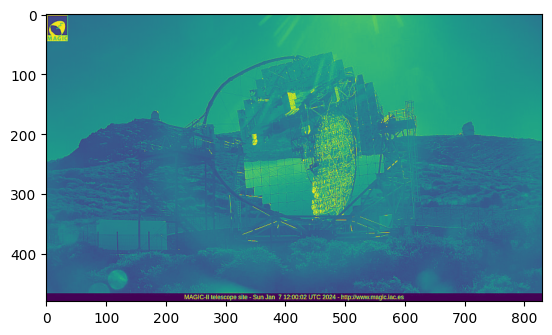

In [151]:
en_i = list(f["images"].keys())[148]
plt.imshow(np.array(f["images"][en_i]["image"]))

In [145]:
dbscan_labels

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  2,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  3,  3,  2,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [146]:
f = h5py.File(H5_PATH, "r")
for label, entry_name in zip(dbscan_labels, f["images"]):
    if label == -1:
        print(entry_name, label)

entry_100 -1
entry_108 -1
entry_148 -1
entry_149 -1
